In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score2, add_hist
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# for model
import segmentation_models_pytorch as smp

from tqdm import tqdm

# for 온라인 바로 제출
import requests
from urllib.parse import urlparse, parse_qsl, urlencode, urlunparse

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장
######################################################################
################## 하이퍼 파라미터 세팅 및 Seed 고정 ####################
######################################################################
batch_size = 8   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [2]:
####################################################################################################
################################# utils ###########################################################
###################################################################################################
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def label_accuracy_score2(hist):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    # hist 모으던 부분이 삭제
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    
    return acc, acc_cls, mean_iu, fwavacc

######################################################################################################
########################################### 라벨링 ###################################################
#####################################################################################################

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = [cat_it['name'] for cat_it in categories]

# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
####################################################################################################
##########################################  Dataset 정의 ############################################
##################################################################################################

category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            # print("image_infos['id'] : {}".format(image_infos['id']) )
            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
##########################################################################################################
################################### Dataset 정의 #######################################################
##########################################################################################################

# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([ToTensorV2()])
val_transform = A.Compose([ToTensorV2()])
test_transform = A.Compose([ToTensorV2()])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

loading annotations into memory...
Done (t=3.94s)
creating index...
index created!
loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
def train2(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, checkpoint_dir, save_file_name,
          start_epoch=0, best_mIoU = -1, best_loss = 99999):
    start_train_time = time.time() # for time check

    print('Start training..')
    
    best_mIoU = best_mIoU
    best_loss = best_loss
    # early_cnt = 0
    for epoch in range(start_epoch, num_epochs): # start_epoch 부터 num_epochs까지
        
        start_epoch_time = time.time() # for time check
        
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)

            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            ''' Gradient Accumulation
            if (idx+1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 mIoU 출력 및 best model 저장 & loss 는 여기서 활용 X
        if (epoch + 1) % val_every == 0:
            
            _, _, mIoU, _, avrg_loss = validation2(epoch+1, model, val_loader, criterion, device)
            
            ################################ 필요시 수정 필요 #######################################
            # 1. 기준 loss & mIoU
            is_best = True if avrg_loss < best_loss and mIoU > best_mIoU else False
            # 2. 기준 loss
            # is_best = True if avrg_loss < best_loss else False
            # 3. 기준 mIoU
            is_best = True if mIoU > best_mIoU else False
            #######################################################################################
            best_loss, best_mIoU= min(best_loss, avrg_loss), max(best_mIoU, mIoU)
            
            save_model2(model=model, saved_dir=saved_dir, is_best=is_best,
                        epoch=epoch, optimizer=optimizer,
                        loss=avrg_loss, mIoU=mIoU,
                        best_loss=best_loss, best_mIoU=best_mIoU,
                        checkpoint_dir=checkpoint_dir, save_file_name=save_file_name
                       )
        # 스케줄러 추가한다면 요자리
        # scheduler.step()
        # earlystop 위치한다면 이자리
        # if best_mIoU == mIoU: early_cnt += 1
        # if early_cnt >= early_th: break
        print(f'시간 소요 for each 1 epoch{epoch}: {int((time.time()-start_epoch_time)//60)}분 {int((time.time()-start_epoch_time)%60)}초') # for time check
    print(f'시간 소요 for total {num_epochs} epoch: {int((time.time()-start_train_time)//60)}분 {int((time.time()-start_train_time)%60)}초') # for time check

def validation2(epoch, model, data_loader, criterion, device, n_class=12):
    start_val_time = time.time() # for time check
    
    print(f'Start validation #{epoch}')
    
    model.eval()
    with torch.no_grad():
        hist = np.zeros((n_class, n_class)) # for mIoU
        total_loss, cnt = 0, 0 # for loss
        for step, (images, masks, _) in enumerate(data_loader):
            
            # 입력 준비
            images = torch.stack(images).to(device)       # (batch, channel, height, width)
            masks = torch.stack(masks).long().to(device)  # (batch, channel, height, width)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1

            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            
            # hist 누적 for mIoU
            for lt, lp in zip(masks.detach().cpu().numpy(), outputs):
                hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

        acc, acc_cls, mIoU, fwavacc = label_accuracy_score2(hist) # for mIoU
        avrg_loss = total_loss / cnt # for loss
        
        print(f'Validation #{epoch}  loss:{avrg_loss:.4f}, mIoU: {mIoU:.4f}')
        print(f'시간 소요 for validation: {int((time.time()-start_val_time)//60)}분 {int((time.time()-start_val_time)%60)}초')
    
    return acc, acc_cls, mIoU, fwavacc, avrg_loss

def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    start_test_time = time.time()
    print(f'Start test.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    start_step_time = time.time()
            
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            if step+1 % 25 == 0:
                print(f'시간소요 [{step}/{len(test_loader)}]: {int(time.time()-start_step_time)}초, 누적 {int((time.time()-start_test_time)//60)}분{int((time.time()-start_test_time)%60)}초')
                start_step_time = time.time()
    print("End prediction.")
    print(f'시간소요 전체 Test: {int((time.time()-start_test_time)//60)}분 {int((time.time()-start_test_time)%60)}초')
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

############################################################################################
################################ Model save Function Define ################################
############################################################################################

val_every = 1 
###################################필요시 수정##############################################
saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

checkpoint_dir = './checkpoint'
if not os.path.isdir(checkpoint_dir):                                                           
    os.mkdir(checkpoint_dir)
############################################################################################
    
def save_model2(model, saved_dir, is_best, epoch, optimizer, loss, mIoU, best_loss, best_mIoU, checkpoint_dir, save_file_name):
    save_data = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'loss': loss,
        'mIoU': mIoU,
        'best_loss': best_loss,
        'best_mIoU': best_mIoU,
    }
    if is_best:
        # 최고 성능 값만 저장
        torch.save(save_data, os.path.join(saved_dir, save_file_name+'.pt'))
        print(f'Best performance(mIoU & loss) at epoch: {epoch + 1}')
    
    # 체크포인트, 매 호출마다 저장 => 특정 횟수차마다 추가 저장
    if (epoch+1) % 10 == 0:
        torch.save(save_data, os.path.join(checkpoint_dir, f'cp{save_file_name}_epoch{epoch+1}.pt'))
        Print(f'Check Point save as cp{save_file_name}_epoch{epoch+1}.pt')
    
    torch.save(save_data, os.path.join(checkpoint_dir, 'cp'+save_file_name+'.pt'))
    print(f'Save last checkpoint.')

####################################################################################################
######################################### 다운로드 없이 제출위한 코드 #################################
####################################################################################################

def submit(user_key='', file_path = '', desc=""):
    if not user_key:
        raise Exception("No UserKey" )
    url = urlparse('http://ec2-13-124-161-225.ap-northeast-2.compute.amazonaws.com:8000/api/v1/competition/28/presigned_url/?description=&hyperparameters={%22training%22:{},%22inference%22:{}}')
    qs = dict(parse_qsl(url.query))
    qs['description'] = desc
    parts = url._replace(query=urlencode(qs))
    url = urlunparse(parts)

    print(url)
    headers = {
        'Authorization': user_key
    }
    res = requests.get(url, headers=headers)
    print(res.text)
    data = json.loads(res.text)
    
    submit_url = data['url']
    body = {
        'key':'app/Competitions/000028/Users/{}/Submissions/{}/output.csv'.format(str(data['submission']['user']).zfill(8),str(data['submission']['local_id']).zfill(4)),
        'x-amz-algorithm':data['fields']['x-amz-algorithm'],
        'x-amz-credential':data['fields']['x-amz-credential'],
        'x-amz-date':data['fields']['x-amz-date'],
        'policy':data['fields']['policy'],
        'x-amz-signature':data['fields']['x-amz-signature']
    }
    requests.post(url=submit_url, data=body, files={'file': open(file_path, 'rb')})

In [4]:
######################### batch_size 바꿀때마다 실행 필요 ########################################

batch_size = 8

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=4,
                                         drop_last=True,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          drop_last=True,
                                          collate_fn=collate_fn)

In [5]:
# 학습
save_file_name='test1' # 저장 시킬때 사용시킬 파일명
model = smp.FPN(
            encoder_name='dpn68b',
            classes=12 ,
            encoder_weights='imagenet+5k'
        ).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
################################## for 이어하기 #################################################
# cp = torch.load(f'./saved/{save_file_name}') # cp(checkpoint) 저장된 경로에 맞게 수정

# model.load_state_dict(cp['model_state_dict'])
# optimizer.load_state_dict(cp['optim_state_dict'])

# start_epoch =cp['epoch'] if 'epoch' in cp else 0
# best_mIoU =cp['best_mIoU'] if 'best_mIoU' in cp else 0
# best_loss =cp['best_loss'] if 'best_loss' in cp else 999999
################################################################################################


train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name,
       ######################################## for 이어하기 ####################################
       start_epoch=start_epoch, best_mIoU=best_mIoU, best_loss=best_loss
       #########################################################################################
      )

Start training..
Epoch [4/25], Step [25/327], Loss: 0.1291
Epoch [4/25], Step [50/327], Loss: 0.1383
Epoch [4/25], Step [75/327], Loss: 0.1543
Epoch [4/25], Step [100/327], Loss: 0.2131
Epoch [4/25], Step [125/327], Loss: 0.1962
Epoch [4/25], Step [150/327], Loss: 0.1868
Epoch [4/25], Step [175/327], Loss: 0.1748
Epoch [4/25], Step [200/327], Loss: 0.2430
Epoch [4/25], Step [225/327], Loss: 0.2337
Epoch [4/25], Step [250/327], Loss: 0.1669
Epoch [4/25], Step [275/327], Loss: 0.3251
Epoch [4/25], Step [300/327], Loss: 0.3596
Epoch [4/25], Step [325/327], Loss: 0.2535
Start validation #4
Validation #4  loss:0.3378, mIoU: 0.4338
시간 소요 for validation: 0분 18초
Best performance(mIoU & loss) at epoch: 4
Save last checkpoint.
시간 소요 for each 1 epoch3: 3분 12초
Epoch [5/25], Step [25/327], Loss: 0.2407


KeyboardInterrupt: 

In [21]:
# 새로운 학습

save_file_name='FPN_timm-resnext50_32x4d_batch8'
model = smp.FPN(
    encoder_name='resnext50_32x4d',
    classes=12 ,
    encoder_weights='swsl'
).to("cuda")
checkpoint = torch.load('./checkpoint/cpFPN_timm-resnext50_32x4d_batch8.pt') # 딕셔너리
model.load_state_dict(checkpoint['model_state_dict']) #
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name,
       start_epoch=checkpoint['epoch'], best_mIou = checkpoint['mIoU'], best_loss = checkpoint['loss']
      )

Start training..
Epoch [12/25], Step [25/328], Loss: 0.1067
Epoch [12/25], Step [50/328], Loss: 0.1608
Epoch [12/25], Step [75/328], Loss: 0.1047
Epoch [12/25], Step [100/328], Loss: 0.0999
Epoch [12/25], Step [125/328], Loss: 0.0763
Epoch [12/25], Step [150/328], Loss: 0.0908
Epoch [12/25], Step [175/328], Loss: 0.1696
Epoch [12/25], Step [200/328], Loss: 0.1101
Epoch [12/25], Step [225/328], Loss: 0.1289
Epoch [12/25], Step [250/328], Loss: 0.1020
Epoch [12/25], Step [275/328], Loss: 0.0950
Epoch [12/25], Step [300/328], Loss: 0.0784
Epoch [12/25], Step [325/328], Loss: 0.1839
Start validation #12
Validation #12  loss:0.3193, mIoU: 0.4958
시간 소요 for validation: 0분 20초
Best performance(mIoU) at epoch: 12
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch11: 3분 25초
Epoch [13/25], Step [25/328], Loss: 0.0696
Epoch [13/25], Step [50/328], Loss: 0.0696
Epoch [13/25], Step [75/328], Loss: 0.0855
Epoch [13/25], Step [100/328], Loss: 0.0935
Epoch [13/25], Step [125/3

In [18]:
# 새로운 학습

save_file_name='FPN_timm-resnext50_32x4d_batch8'
model = smp.FPN(
    encoder_name='resnext50_32x4d',
    classes=12 ,
    encoder_weights='swsl'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)


Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth" to /opt/ml/.cache/torch/checkpoints/semi_weakly_supervised_resnext50_32x4-72679e44.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Start training..
Epoch [1/25], Step [25/328], Loss: 1.3470
Epoch [1/25], Step [50/328], Loss: 0.4740
Epoch [1/25], Step [75/328], Loss: 0.4651
Epoch [1/25], Step [100/328], Loss: 0.5390
Epoch [1/25], Step [125/328], Loss: 0.8278
Epoch [1/25], Step [150/328], Loss: 0.4230
Epoch [1/25], Step [175/328], Loss: 0.4523
Epoch [1/25], Step [200/328], Loss: 0.6579
Epoch [1/25], Step [225/328], Loss: 0.3457
Epoch [1/25], Step [250/328], Loss: 0.3379
Epoch [1/25], Step [275/328], Loss: 0.3593
Epoch [1/25], Step [300/328], Loss: 0.5804
Epoch [1/25], Step [325/328], Loss: 0.4755
Start validation #1
Validation #1  loss:0.4031, mIoU: 0.3215
시간 소요 for validation: 0분 19초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 3분 19초
Epoch [2/25], Step [25/328], Loss: 0.3295
Epoch [2/25], Step [50/328], Loss: 0.3850
Epoch [2/25], Step [75/328], Loss: 0.4430
Epoch [2/25], Step [100/328], Loss: 0.5389
Epoch [2/25], Step [125/328], Loss: 0.4435
Epoc

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

In [8]:
# 새로운 학습

save_file_name='DeepLavb3+_dpn92_batch8'
model = smp.DeepLabV3Plus(
    encoder_name='dpn92',
    classes=12 ,
    encoder_weights='imagenet+5k'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn92_extra-fda993c95.pth" to /opt/ml/.cache/torch/checkpoints/dpn92_extra-fda993c95.pth


  0%|          | 0.00/144M [00:00<?, ?B/s]

Start training..
Epoch [1/25], Step [25/164], Loss: 1.2455
Epoch [1/25], Step [50/164], Loss: 0.9135
Epoch [1/25], Step [75/164], Loss: 0.7360
Epoch [1/25], Step [100/164], Loss: 0.6542
Epoch [1/25], Step [125/164], Loss: 0.5958
Epoch [1/25], Step [150/164], Loss: 0.7502
Start validation #1
Validation #1  loss:0.4503, mIoU: 0.3725
시간 소요 for validation: 0분 29초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 6분 15초
Epoch [2/25], Step [25/164], Loss: 0.3639
Epoch [2/25], Step [50/164], Loss: 0.4096
Epoch [2/25], Step [75/164], Loss: 0.3544
Epoch [2/25], Step [100/164], Loss: 0.3063
Epoch [2/25], Step [125/164], Loss: 0.4148
Epoch [2/25], Step [150/164], Loss: 0.3322
Start validation #2
Validation #2  loss:0.3442, mIoU: 0.4176
시간 소요 for validation: 0분 29초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 6분 19초
Epoch [3/25], Step [25/164], Loss: 0.2403
Epoch [3/

In [7]:
# 새로운 학습

save_file_name='DeepLavb3+_dpn68_batch8'
model = smp.DeepLabV3Plus(
    encoder_name='dpn68',
    classes=12 ,
    encoder_weights='imagenet'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn68-4af7d88d2.pth" to /opt/ml/.cache/torch/checkpoints/dpn68-4af7d88d2.pth


  0%|          | 0.00/48.4M [00:00<?, ?B/s]

Start training..
Epoch [1/25], Step [25/164], Loss: 1.4747
Epoch [1/25], Step [50/164], Loss: 0.9364
Epoch [1/25], Step [75/164], Loss: 0.7485
Epoch [1/25], Step [100/164], Loss: 0.8647
Epoch [1/25], Step [125/164], Loss: 0.6242
Epoch [1/25], Step [150/164], Loss: 0.5500
Start validation #1
Validation #1  loss:0.5301, mIoU: 0.2994
시간 소요 for validation: 0분 20초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 3분 59초
Epoch [2/25], Step [25/164], Loss: 0.4440
Epoch [2/25], Step [50/164], Loss: 0.4039
Epoch [2/25], Step [75/164], Loss: 0.5423
Epoch [2/25], Step [100/164], Loss: 0.3818
Epoch [2/25], Step [125/164], Loss: 0.3449
Epoch [2/25], Step [150/164], Loss: 0.4780
Start validation #2
Validation #2  loss:0.3767, mIoU: 0.3954
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 4분 1초
Epoch [3/25], Step [25/164], Loss: 0.3951
Epoch [3/2

In [8]:
# 새로운 학습

save_file_name='DeepLavb3+_dpn68b_batch8'
model = smp.DeepLabV3Plus(
    encoder_name='dpn68b',
    classes=12 ,
    encoder_weights='imagenet+5k'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(25, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Start training..
Epoch [1/25], Step [25/164], Loss: 1.4475
Epoch [1/25], Step [50/164], Loss: 0.9530
Epoch [1/25], Step [75/164], Loss: 0.7665
Epoch [1/25], Step [100/164], Loss: 0.8745
Epoch [1/25], Step [125/164], Loss: 0.6058
Epoch [1/25], Step [150/164], Loss: 0.5411
Start validation #1
Validation #1  loss:0.5225, mIoU: 0.3019
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 4분 0초
Epoch [2/25], Step [25/164], Loss: 0.4529
Epoch [2/25], Step [50/164], Loss: 0.3980
Epoch [2/25], Step [75/164], Loss: 0.5344
Epoch [2/25], Step [100/164], Loss: 0.3733
Epoch [2/25], Step [125/164], Loss: 0.3856
Epoch [2/25], Step [150/164], Loss: 0.4795
Start validation #2
Validation #2  loss:0.3918, mIoU: 0.3765
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 4분 1초
Epoch [3/25], Step [25/164], Loss: 0.3611
Epoch [3/25

NameError: name 'best_mIoU' is not defined

In [7]:
# 새로운 학습

save_file_name='Unet++_timm-skresnet34'
model = smp.UnetPlusPlus(
    encoder_name='timm-skresnet34',
    classes=12 ,
    encoder_weights='imagenet'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)
best_mIoU

Start training..
Epoch [1/150], Step [25/164], Loss: 2.0008
Epoch [1/150], Step [50/164], Loss: 1.6500
Epoch [1/150], Step [75/164], Loss: 1.5365
Epoch [1/150], Step [100/164], Loss: 1.1752
Epoch [1/150], Step [125/164], Loss: 1.2324
Epoch [1/150], Step [150/164], Loss: 0.9418
Start validation #1
Validation #1  loss:0.8847, mIoU: 0.1937
시간 소요 for validation: 0분 30초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 5분 6초
Epoch [2/150], Step [25/164], Loss: 0.6831
Epoch [2/150], Step [50/164], Loss: 0.7115
Epoch [2/150], Step [75/164], Loss: 0.7539
Epoch [2/150], Step [100/164], Loss: 0.5597
Epoch [2/150], Step [125/164], Loss: 0.5282
Epoch [2/150], Step [150/164], Loss: 0.6633
Start validation #2
Validation #2  loss:0.5417, mIoU: 0.2440
시간 소요 for validation: 0분 30초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 5분 9초
Epoch [3/150], Step [25/164], Loss: 0.662

KeyboardInterrupt: 

In [7]:
# 새로운 학습

save_file_name='DeepLabV3Plus_timm-skresnet34'
model = smp.DeepLabV3Plus(
    encoder_name='timm-skresnet34',
    classes=12 ,
    encoder_weights='imagenet'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)
best_mIoU

Start training..
Epoch [1/150], Step [25/164], Loss: 1.4527
Epoch [1/150], Step [50/164], Loss: 1.1054
Epoch [1/150], Step [75/164], Loss: 0.9430
Epoch [1/150], Step [100/164], Loss: 0.6242
Epoch [1/150], Step [125/164], Loss: 0.6816
Epoch [1/150], Step [150/164], Loss: 0.4992
Start validation #1
Validation #1  loss:0.5328, mIoU: 0.2717
시간 소요 for validation: 0분 19초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 3분 11초
Epoch [2/150], Step [25/164], Loss: 0.4728
Epoch [2/150], Step [50/164], Loss: 0.4598
Epoch [2/150], Step [75/164], Loss: 0.4061
Epoch [2/150], Step [100/164], Loss: 0.3842
Epoch [2/150], Step [125/164], Loss: 0.3926
Epoch [2/150], Step [150/164], Loss: 0.2995
Start validation #2
Validation #2  loss:0.4223, mIoU: 0.3411
시간 소요 for validation: 0분 19초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 3분 10초
Epoch [3/150], Step [25/164], Loss: 0.3

KeyboardInterrupt: 

In [7]:
# 새로운 학습

save_file_name='Unet_se_resnet50'

model = smp.Unet(
    encoder_name='se_resnet50',
    classes=12 ,
    encoder_weights='imagenet'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Start training..
Epoch [1/150], Step [25/328], Loss: 1.7150
Epoch [1/150], Step [50/328], Loss: 1.3732
Epoch [1/150], Step [75/328], Loss: 1.1918
Epoch [1/150], Step [100/328], Loss: 1.3854
Epoch [1/150], Step [125/328], Loss: 0.7453
Epoch [1/150], Step [150/328], Loss: 0.8868
Epoch [1/150], Step [175/328], Loss: 0.6436
Epoch [1/150], Step [200/328], Loss: 0.6622
Epoch [1/150], Step [225/328], Loss: 0.6598
Epoch [1/150], Step [250/328], Loss: 0.5938
Epoch [1/150], Step [275/328], Loss: 0.4423
Epoch [1/150], Step [300/328], Loss: 0.7040
Epoch [1/150], Step [325/328], Loss: 0.5708
Start validation #1
Validation #1  loss:0.6052, mIoU: 0.1702
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 3분 38초
Epoch [2/150], Step [25/328], Loss: 0.7870
Epoch [2/150], Step [50/328], Loss: 0.6469
Epoch [2/150], Step [75/328], Loss: 0.4331
Epoch [2/150], Step [100/328], Loss: 0.3918
Epoch [2/150], Step [125/328],

KeyboardInterrupt: 

In [8]:
# # 새로운 학습

# save_file_name='Unet++_se_resnet50'

# model = smp.UnetPlusPlus(
#     encoder_name='se_resnet50',
#     classes=12 ,
#     encoder_weights='imagenet'
# ).to("cuda")
# # checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# # model.load_state_dict(checkpoint['model_state_dict'])
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# # optimizer.load_state_dict(checkpoint['optim_state_dict'])
# train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
#        checkpoint_dir, save_file_name)

Start training..
Epoch [1/150], Step [25/328], Loss: 2.0730
Epoch [1/150], Step [50/328], Loss: 2.0131
Epoch [1/150], Step [75/328], Loss: 1.6565
Epoch [1/150], Step [100/328], Loss: 1.6311
Epoch [1/150], Step [125/328], Loss: 1.4610
Epoch [1/150], Step [150/328], Loss: 1.2848
Epoch [1/150], Step [175/328], Loss: 1.0718
Epoch [1/150], Step [200/328], Loss: 1.0089
Epoch [1/150], Step [225/328], Loss: 1.0255
Epoch [1/150], Step [250/328], Loss: 1.0026
Epoch [1/150], Step [275/328], Loss: 0.9357
Epoch [1/150], Step [300/328], Loss: 0.6295
Epoch [1/150], Step [325/328], Loss: 0.7152
Start validation #1
Validation #1  loss:0.7422, mIoU: 0.1724
시간 소요 for validation: 0분 54초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 10분 39초
Epoch [2/150], Step [25/328], Loss: 0.7686
Epoch [2/150], Step [50/328], Loss: 0.7417
Epoch [2/150], Step [75/328], Loss: 0.5994
Epoch [2/150], Step [100/328], Loss: 0.8473
Epoch [2/150], Step [125/328]

KeyboardInterrupt: 

In [8]:
# 새로운 학습

save_file_name='LinkNet_timm-effi-b0_mIoU_ce'

model = smp.Linknet(
    encoder_name='timm-efficientnet-b0',
    classes=12 ,
    encoder_weights='noisy-student'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Start training..
Epoch [1/150], Step [25/164], Loss: 2.4601
Epoch [1/150], Step [50/164], Loss: 2.3792
Epoch [1/150], Step [75/164], Loss: 2.2977
Epoch [1/150], Step [100/164], Loss: 2.3184
Epoch [1/150], Step [125/164], Loss: 2.2514
Epoch [1/150], Step [150/164], Loss: 2.0717
Start validation #1
Validation #1  loss:2.0874, mIoU: 0.0349
시간 소요 for validation: 0분 16초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 2분 17초
Epoch [2/150], Step [25/164], Loss: 2.0098
Epoch [2/150], Step [50/164], Loss: 1.9503
Epoch [2/150], Step [75/164], Loss: 1.9570
Epoch [2/150], Step [100/164], Loss: 1.8730
Epoch [2/150], Step [125/164], Loss: 1.8284
Epoch [2/150], Step [150/164], Loss: 1.7652
Start validation #2
Validation #2  loss:1.7290, mIoU: 0.0615
시간 소요 for validation: 0분 16초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 2분 18초
Epoch [3/150], Step [25/164], Loss: 1.7

KeyboardInterrupt: 

In [9]:
# 새로운 학습
import segmentation_models_pytorch as smp

save_file_name='UnetPlusPlus_timm-effi-b4_mIoU_ce'

model = smp.UnetPlusPlus(
    encoder_name='timm-efficientnet-b4',
    classes=12 ,
    encoder_weights='noisy-student'
).to("cuda")
# checkpoint = torch.load('./saved/Unet++_20epoch_save.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer.load_state_dict(checkpoint['optim_state_dict'])
train2(150, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Start training..
Epoch [1/150], Step [25/328], Loss: 2.1738
Epoch [1/150], Step [50/328], Loss: 1.8176
Epoch [1/150], Step [75/328], Loss: 1.5306
Epoch [1/150], Step [100/328], Loss: 1.3255
Epoch [1/150], Step [125/328], Loss: 1.2177
Epoch [1/150], Step [150/328], Loss: 1.2617
Epoch [1/150], Step [175/328], Loss: 0.9001
Epoch [1/150], Step [200/328], Loss: 0.7143
Epoch [1/150], Step [225/328], Loss: 0.5997
Epoch [1/150], Step [250/328], Loss: 0.8002
Epoch [1/150], Step [275/328], Loss: 0.6814
Epoch [1/150], Step [300/328], Loss: 0.5633
Epoch [1/150], Step [325/328], Loss: 0.5855
Start validation #1
Validation #1  loss:0.5755, mIoU: 0.1764
시간 소요 for validation: 0분 31초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 6분 23초
Epoch [2/150], Step [25/328], Loss: 0.6151
Epoch [2/150], Step [50/328], Loss: 0.8258
Epoch [2/150], Step [75/328], Loss: 0.5243
Epoch [2/150], Step [100/328], Loss: 0.3787
Epoch [2/150], Step [125/328],

KeyboardInterrupt: 

In [8]:
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
# scheduler = StepLR(optimizer, lr_decay_step, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, )
# scheduler.get_last_lr()
# scheduler.step()

In [9]:
train2(50, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device,
       checkpoint_dir, save_file_name)

Start training..
Epoch [1/50], Step [25/164], Loss: 2.2182
Epoch [1/50], Step [50/164], Loss: 1.9311
Epoch [1/50], Step [75/164], Loss: 1.6495
Epoch [1/50], Step [100/164], Loss: 1.4953
Epoch [1/50], Step [125/164], Loss: 1.4266
Epoch [1/50], Step [150/164], Loss: 1.2389
Start validation #1
Validation #1  loss:1.1750, mIoU: 0.1050
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 1
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch0: 3분 23초
Epoch [2/50], Step [25/164], Loss: 1.0578
Epoch [2/50], Step [50/164], Loss: 1.0181
Epoch [2/50], Step [75/164], Loss: 1.0068
Epoch [2/50], Step [100/164], Loss: 0.9493
Epoch [2/50], Step [125/164], Loss: 0.9410
Epoch [2/50], Step [150/164], Loss: 0.8450
Start validation #2
Validation #2  loss:0.9137, mIoU: 0.1127
시간 소요 for validation: 0분 21초
Best performance(mIoU) at epoch: 2
Save model in ./saved
Save checkpoint in ./checkpoint
시간 소요 for each 1 epoch1: 3분 23초
Epoch [3/50], Step [25/164], Loss: 0.7296
Epoch [3/

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {9, 'Plastic bag'}]


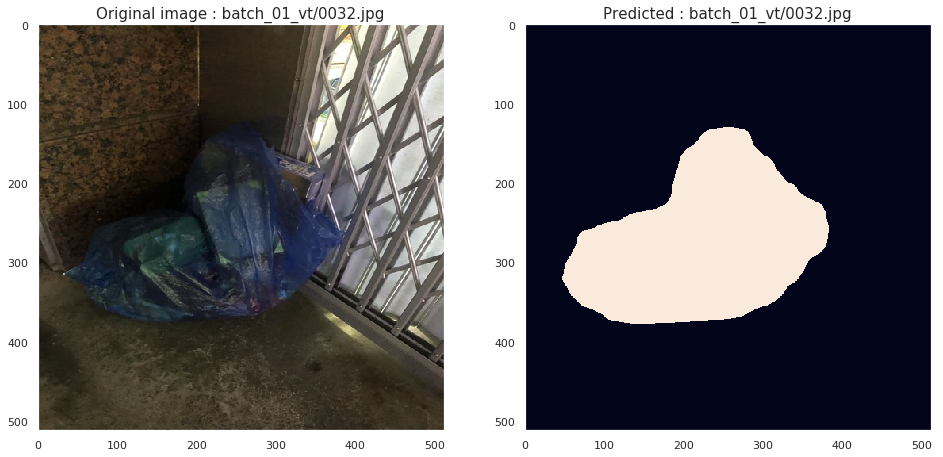

Start test.


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [8]:
############# submission 생성 및 제출에 사용할 파일설정 #####################

save_file_name='test1' # submission의 저장 될 파일명
model_path = f'./saved/{save_file_name}.pt' # 사용할 파일 주소 (저는 동일하게 사용해서 저렇게 사용중)

desc = f"{save_file_name} #20 loss:0.3352, mIoU: 0.5521" # 제출시 Describe에 적힐 멘트
output_file = f"{save_file_name}.csv" # 제출 될 submission의 파일명 => 기본 탐색 위치 './submission/'
#########################################################################
################ model 불러오기###########################################
#########################################################################

########################### 알맞게 수정 필요 ###############################
model = smp.FPN(
    encoder_name='dpn68b',
    classes=12 ,
    encoder_weights='imagenet+5k'
).to("cuda")
cp = torch.load(model_path)
model.load_state_dict(cp['model_state_dict'])


############################################################################
########################## 첫번째 이미지 추론 결과 미리보기####################
###########################################################################

for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

############################################################################
########################## Submission.csv 생성 #############################
###########################################################################

# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)
# submission.csv로 저장
############################## 파일 저장 명칭 필요시 수정 #######################################
submission.to_csv(f"./submission/{save_file_name}.csv", index=False)
print(f'{save_file_name}.csv save complete.')
##############################################################################################

##########################################################################################
################################# Submission.csv 제출 ###################################
#######################################################################################
#################################필요시 수정 ##############################################

test_dir = "./submission/"
# desc = f"{save_file_name} Validation # 맨 위에서 선언 하도록 수정
# output_file = f"{save_file_name}.csv" # 맨 위에서 선언 하도록 수정
user_key = "Bearer 나의Authorization값" # 수정 필요

##########################################################################################

# submit(user_key, os.path.join(test_dir, output_file),desc)
print(f'{output_file} submit complete.')